In [18]:
import sqlite3
import requests

# Download the SQL script
url = "https://raw.githubusercontent.com/jpwhite3/northwind-SQLite3/refs/heads/main/src/create.sql"
response = requests.get(url)
sql_script = response.text

# Create the SQLite database
conn = sqlite3.connect('northwind.db')
cursor = conn.cursor()

# Execute the SQL script to create the database
cursor.executescript(sql_script)
conn.commit()

# Perform basic data analysis
# Example: Get the number of customers
cursor.execute("SELECT COUNT(*) FROM Customers")
num_customers = cursor.fetchone()[0]
print(f"Number of categories: {num_customers}")

# Example: Get the number of orders
cursor.execute("SELECT COUNT(*) FROM Orders")
num_orders = cursor.fetchone()[0]
print(f"Number of orders: {num_orders}")

# Example: Get the top 5 products by quantity ordered
cursor.execute("""
    SELECT ProductName, SUM(Quantity) as TotalQuantity
    FROM [Order Details]
    JOIN Products ON [Order Details].ProductID = Products.ProductID
    GROUP BY ProductName
    ORDER BY TotalQuantity DESC
    LIMIT 5
""")
top_products = cursor.fetchall()
print("Top 5 products by quantity ordered:")
for product in top_products:
    print(f"{product[0]}: {product[1]}")

# Close the connection
conn.close()

Number of categories: 93
Number of orders: 830
Top 5 products by quantity ordered:
Camembert Pierrot: 1577
Raclette Courdavault: 1496
Gorgonzola Telino: 1397
Gnocchi di nonna Alice: 1263
Pavlova: 1158


In [23]:
import pandas as pd
import numpy as np

# Reconnect to the SQLite database
conn = sqlite3.connect('northwind.db')
# cursor = conn.cursor()

# Load data from the database into pandas DataFrames
customers_df = pd.read_sql_query("SELECT * FROM Customers", conn)
orders_df = pd.read_sql_query("SELECT * FROM Orders", conn)
order_details_df = pd.read_sql_query("SELECT * FROM [Order Details]", conn)
products_df = pd.read_sql_query("SELECT * FROM Products", conn)

conn.close()

# Perform basic analysis
# Example: Calculate the total sales for top 10 products
order_details_df['TotalPrice'] = order_details_df['UnitPrice'] * order_details_df['Quantity'] * (1 - order_details_df['Discount'])
total_sales_per_product = order_details_df.groupby('ProductID')['TotalPrice'].sum().reset_index()
total_sales_per_product = total_sales_per_product.merge(products_df[['ProductID', 'ProductName']], on='ProductID')
total_sales_per_product = total_sales_per_product.sort_values('TotalPrice', ascending=False).head(10)

# Example: Calculate the average order value
average_order_value = order_details_df.groupby('OrderID')['TotalPrice'].sum().mean()
print(f"Average order value: {average_order_value:.2f}")

# Example: Calculate the number of orders for top 10 customers
orders_per_customer = orders_df.groupby('CustomerID').size().reset_index(name='OrderCount')
orders_per_customer = orders_per_customer.merge(customers_df[['CustomerID', 'CompanyName']], on='CustomerID')
orders_per_customer = orders_per_customer.sort_values('OrderCount', ascending=False).head(10)

Average order value: 1525.05


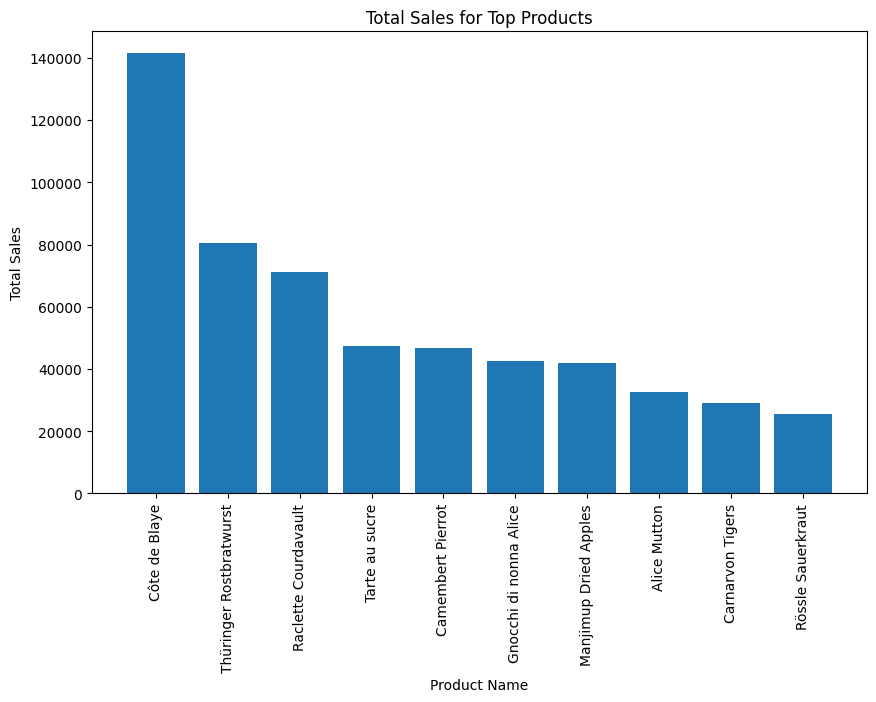

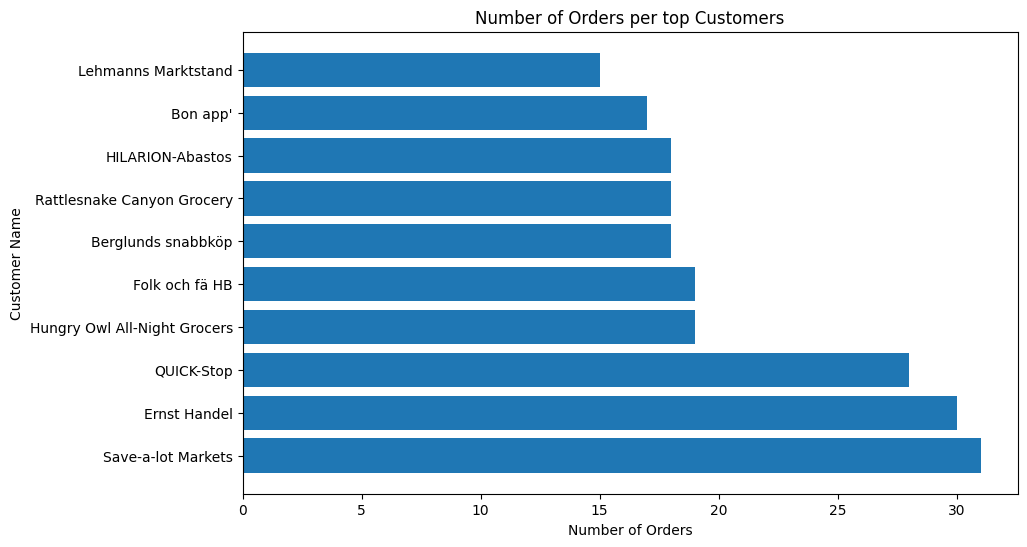

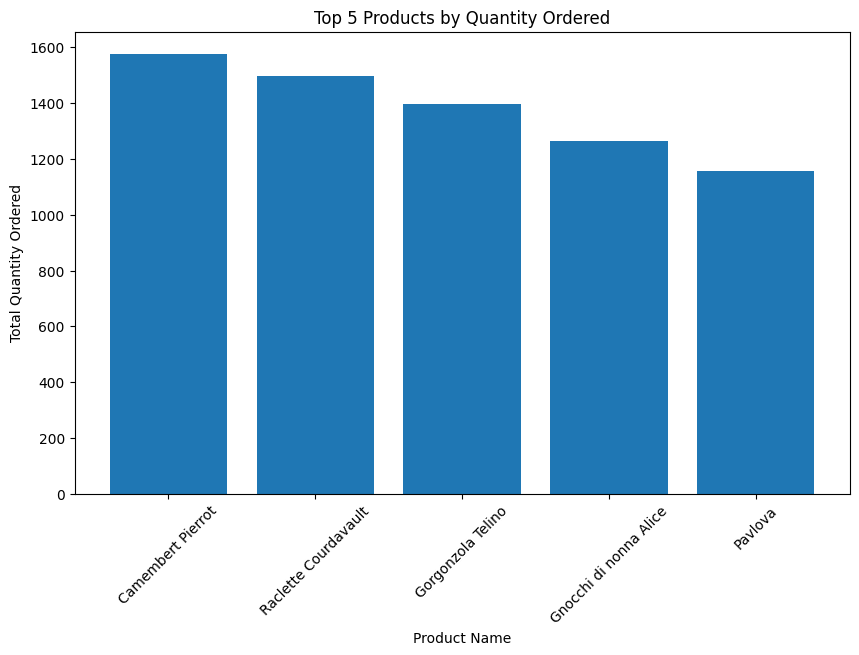

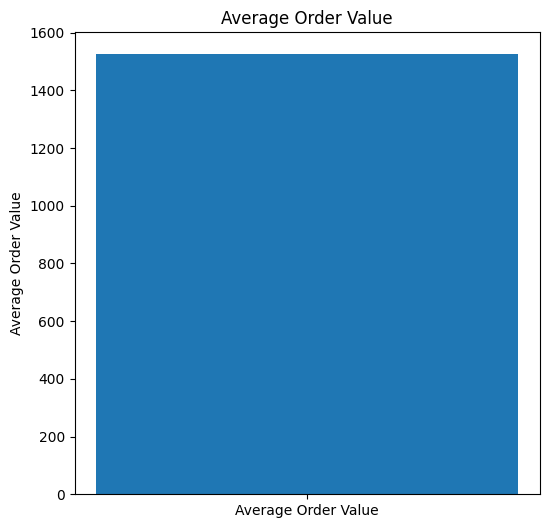

In [ ]:
import matplotlib.pyplot as plt

# Plot the total sales for top products
plt.figure(figsize=(10, 6))
plt.bar(total_sales_per_product['ProductName'], total_sales_per_product['TotalPrice'])
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.title('Total Sales for Top Products')
plt.xticks(rotation=90)
plt.show()

# Plot the number of orders per customer
plt.figure(figsize=(10, 6))
plt.barh(orders_per_customer['CompanyName'], orders_per_customer['OrderCount'])
plt.ylabel('Customer Name')
plt.xlabel('Number of Orders')
plt.title('Number of Orders per top Customers')
plt.show()

# Convert top_products to a DataFrame
top_products_df = pd.DataFrame(top_products, columns=['ProductName', 'TotalQuantity'])

# Plot the top 5 products by quantity ordered
plt.figure(figsize=(10, 6))
plt.bar(top_products_df['ProductName'], top_products_df['TotalQuantity'])
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Ordered')
plt.title('Top 5 Products by Quantity Ordered')
plt.xticks(rotation=45)
plt.show()